In [44]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
from matplotlib.patches import Rectangle
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

In [45]:
donor = pd.read_csv("/Users/zhenyuan/Desktop/stern_ra/education/merged_new.csv")
# donor = donor.dropna().reset_index()
donor["school_ncesid"] = pd.to_numeric(donor["school_ncesid"], errors='coerce')
donor["ncesid"] = donor["school_ncesid"]//100000
edu = pd.read_csv("/Users/zhenyuan/Desktop/stern_ra/education/seda_cov_school_pool_4.1.csv")
cs = pd.read_csv("/Users/zhenyuan/Desktop/stern_ra/education/seda_school_pool_cs_4.1.csv")

### Independent Variables:
'projectid', 'title', 'short_description','need_statement', 'essay', 'school_ncesid',
'teacher_prefix', 'primary_focus_area', 'resource_type','poverty_level', 'grade_level',

'date_posted'
### Dependent Variables:
'fulfillment_labor_materials', 'total_price_excluding_optional_support', ('total_price_including_optional_support',)
'students_reached', 

### Writings
'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword',  'Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ'


### School Level Attributes
'schoolid', 'school_ncesid','school_latitude', 'school_longitude', 'school_city', 'school_state',
'school_zip', 'school_metro', 'school_district', 'school_county','school_charter', 'school_magnet',
'school_nlns','school_kipp'

## Generate School Dataset (merge with stanford Data)

'schoolid', 'school_ncesid', 'school_latitude', 'school_longitude',
'school_city', 'school_state', 'school_zip', 'school_metro',
'school_district', 'school_county', 'school_charter', 'school_magnet',
'school_nlns', 'school_kipp', 'sedasch', 'sedalea', 'schnam', 'schcity',
'stateabb', 'fips', 'type', 'level', 'mingrd', 'maxgrd', 'charter',
'magnet', 'urbanicity', 'locale', 'sch_sped', 'totenrl', 'perwht',
'pernam', 'perasn', 'perhsp', 'perblk', 'perfl', 'perrl', 'perfrl',
'perecd', 'gifted_tot', 'disab_tot', 'disab_tot_idea', 'lep',
'gifted_flag', 'lep_flag', 'sped_flag', 'spedidea_flag', 'avgrdall',
'sedaschname', 'subcat', 'subgroup', 'gradecenter', 'gap', 'tot_asmts',
'cellcount', 'mn_asmts', 'cs_mn_avg_ol', 'cs_mn_coh_ol', 'cs_mn_grd_ol',
'cs_mn_mth_ol', 'cs_mn_avg_ol_se', 'cs_mn_coh_ol_se', 'cs_mn_grd_ol_se',
'cs_mn_mth_ol_se', 'cs_mn_avg_eb', 'cs_mn_coh_eb', 'cs_mn_grd_eb',
'cs_mn_mth_eb', 'cs_mn_avg_eb_se', 'cs_mn_coh_eb_se', 'cs_mn_grd_eb_se',
'cs_mn_mth_eb_se', 'poverty_level2', 'poverty_level3'

NOTE: Data are for the 50 states and the District of Columbia. Low-poverty schools are defined as public schools where 25.0 percent or less of the students are eligible for free or reduced-price lunch (FRPL); mid-low poverty schools are those where 25.1 to 50.0 percent of the students are eligible for FRPL; mid-high poverty schools are those where 50.1 to 75.0 percent of the students are eligible for FRPL; and high-poverty schools are those where more than 75.0 percent of the students are eligible for FRPL. Data include students whose NSLP eligibility has been determined through direct certification, which is a “process conducted by the states and by local educational agencies (LEAs) to certify eligible children for free meals without the need for household applications” (https://www.fns.usda.gov/direct-certification-national-school-lunch-program-report-congress-state-implementation-progress-1). For more information on eligibility for FRPL and its relationship to poverty, see the NCES blog post “Free or reduced price lunch: A proxy for poverty?” Schools with missing FRPL data are not included in this figure. Race categories exclude persons of Hispanic ethnicity. Detail may not sum to 100 percent because of rounding and because schools with missing FRPL data are not included in this figure. Although rounded numbers are displayed, the figures are based on unrounded data.

SOURCE: U.S. Department of Education, National Center for Education Statistics, Common Core of Data (CCD), “Public Elementary/Secondary School Universe Survey,” 2018–19; and Education Demographic and Geographic Estimates (EDGE), “Public School File,” 2018–19. See Digest of Education Statistics 2020, table 216.60.

In [46]:
school = donor[['schoolid', 'school_ncesid','school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county','school_charter', 'school_magnet',
       'school_nlns','school_kipp']].drop_duplicates(keep="last").reset_index(drop=True)
school = school.dropna(subset=["school_ncesid"])

In [47]:
sfd = pd.merge(edu,cs.drop(columns=['fips','stateabb']),on="sedasch")
school = pd.merge(school,sfd,left_on="school_ncesid",right_on="sedasch",how="left")
### Drop the schools that do not show up in stanford data (11000ish)
school = school[~pd.isna(school["sedasch"])]
school.reset_index(drop=True,inplace=True)

In [48]:
school.loc[(school["perfrl"]<=0.25),"poverty_level2"] = "low-poverty"
school.loc[(school["perfrl"]>0.25)&(school["perfrl"]<=0.5),"poverty_level2"] = "mid-low poverty"
school.loc[(school["perfrl"]>0.5)&(school["perfrl"]<=0.75),"poverty_level2"] = "mid-high poverty"
school.loc[(school["perfrl"]>0.75),"poverty_level2"] = "high-poverty"
school.loc[(school["perfrl"]<=0.5),"poverty_level3"] = "low-poverty"
school.loc[(school["perfrl"]>0.5),"poverty_level3"] = "high-poverty"

In [6]:
school.to_csv(r"/Users/zhenyuan/Desktop/stern_ra/education/school.csv")

In [49]:
school

,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,school_district,school_county,...,cs_mn_avg_eb,cs_mn_coh_eb,cs_mn_grd_eb,cs_mn_mth_eb,cs_mn_avg_eb_se,cs_mn_coh_eb_se,cs_mn_grd_eb_se,cs_mn_mth_eb_se,poverty_level2,poverty_level3
0,53bbfb5417c7f5d88033eccd87e5d786,3.608400e+11,42.152977,-77.063492,Corning,NY,14830.0,NaN,Corning Painted Post Area SD,Steuben,...,0.199396,0.016252,NaN,-0.173425,0.046402,0.017100,NaN,0.060217,mid-low poverty,low-poverty
1,32ca6d5626cfa5ffac49ae8e2eb78b35,5.401620e+11,39.232084,-81.533935,Parkersburg,WV,26101.0,urban,Wood Co School District,Wood,...,-0.447238,-0.008426,0.019687,-0.045165,0.030666,0.009868,0.032821,0.055711,mid-high poverty,high-poverty
2,ef38e1a82a8c2e0ca29cfc635b4c4452,4.500840e+11,34.382023,-82.725548,Starr,SC,29684.0,rural,Anderson School District 3,Anderson,...,-0.108908,0.050844,0.021845,-0.016499,0.021445,0.007348,0.024702,0.040875,mid-high poverty,high-poverty
3,2044955670ce119be05dc238f6ce9bd1,4.102640e+11,45.177341,-122.745682,Hubbard,OR,97032.0,rural,Canby School District 86,Marion,...,0.021501,0.003498,0.066549,-0.103196,0.033643,0.011682,0.019017,0.047068,mid-low poverty,low-poverty
4,b6a253b1dc81f39b96f47a441d20d923,1.200180e+11,26.291576,-80.210793,Coral Springs,FL,33067.0,suburban,Broward Co Public Schools,Broward,...,0.396245,-0.008042,0.003973,0.065107,0.022968,0.007723,0.026052,0.043455,mid-low poverty,low-poverty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40412,f8e49225a821cc04e1176303e55d89ec,1.602640e+11,42.820593,-112.409161,Pocatello,ID,83204.0,urban,Pocatello-Chubbuck District 25,Bannock,...,0.158639,-0.000028,-0.021856,-0.071803,0.023582,0.007644,0.023702,0.043608,mid-high poverty,high-poverty
40413,6c6ea0558a03d113856e828ca7706092,4.827030e+11,30.389966,-97.843495,Austin,TX,78730.0,rural,Leander Ind School District,Travis,...,0.640063,-0.025213,0.043747,-0.079830,0.027500,0.008452,0.026669,0.046578,low-poverty,low-poverty
40414,9655f475102286a53b98ffbabb14013f,3.703780e+11,35.830690,-79.865901,Sophia,NC,27350.0,rural,Randolph Co School District,Randolph,...,0.133819,0.010725,-0.033471,0.188038,0.023693,0.007932,0.026863,0.044708,mid-high poverty,high-poverty
40415,103ed937d8d84fdffe8b87a4811f00bf,1.301230e+11,33.514296,-84.345336,Jonesboro,GA,30236.0,suburban,Clayton Co Public Schools,Clayton,...,-0.273208,-0.038890,-0.029174,-0.100399,0.023394,0.007887,0.026537,0.044193,high-poverty,high-poverty


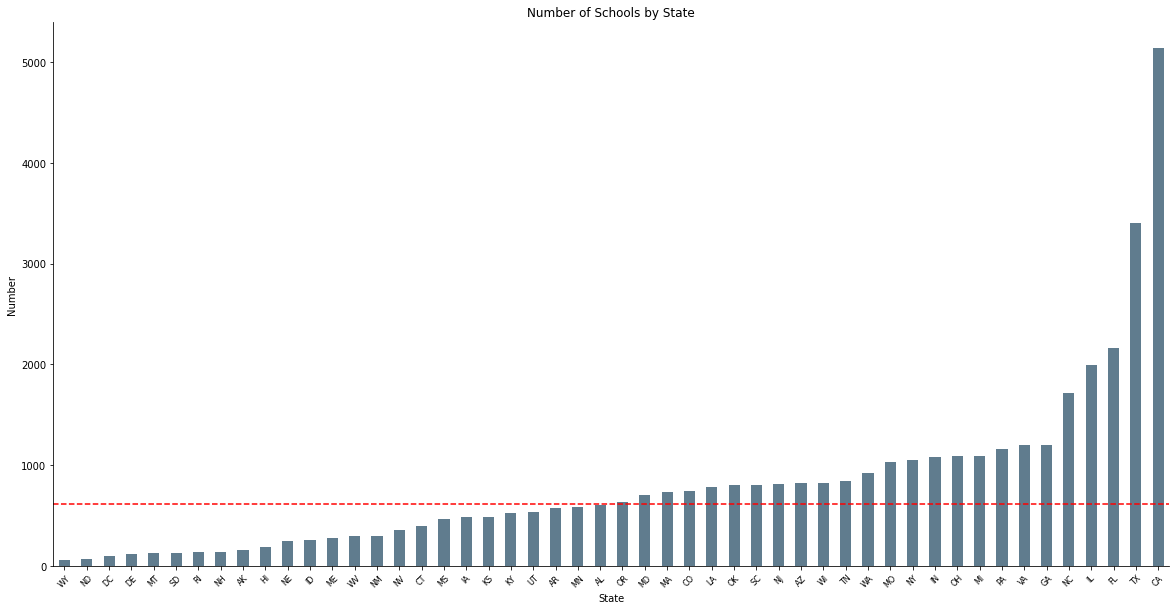

In [50]:
plot_state = school[["school_ncesid","school_state"]].drop_duplicates().groupby("school_state").count().reset_index()
plot_state = plot_state.sort_values(by="school_ncesid")
median = plot_state["school_ncesid"].median()

plot_state.plot.bar(x='school_state', y='school_ncesid', color='#607c8e',figsize=(20,10))
# plt.figure(figsize=(20,10))
plt.xlabel('State')
plt.ylabel('Number')
plt.title('Number of Schools by State')
plt.axhline(y = median, color = 'red', linestyle = '--') 
ax = plt.gca()
ax.get_legend().remove()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(fontsize=8,rotation=45)
plt.savefig('school_distribution.png', format='png')
plt.show()

## Description of Projects

In [51]:
donor['date_posted'] = pd.to_datetime(donor['date_posted'])
donor['year'] = donor['date_posted'].apply(lambda x: x.year)

In [52]:
projects.teacher_prefix.unique()

array(['Mrs.', 'Ms.', 'Mr.', nan, '35.0', '30.0', '2014-03-14',
       'Grades 3-5', 'Grades PreK-2', '9.0', '2011-11-28', '17.0',
       '2014-04-02', '2014-01-14', '2013-09-15', '2012-10-08',
       '2014-03-11', 'Grades 6-8', '2012-01-21', '2011-12-27',
       '2014-05-10', '2014-04-18', '2012-12-12', '2012-01-16',
       '2012-03-08', '2012-02-05', '2014-03-20', '2012-02-04',
       '2012-01-19', '2012-09-08', '2012-01-29', '2012-02-06',
       '2008-09-02', '2013-01-09', '2012-02-18', '2012-12-22',
       '2012-12-08', '2014-05-08', '2008-01-16', '2013-05-08',
       '2013-08-26', '2011-11-27', '2012-01-30', '2012-11-03',
       '2012-02-07', '2013-05-13', '2012-07-23', '2008-05-29',
       '2011-09-17', '2011-11-30', '2014-03-27', '2011-09-19',
       '2013-04-06', '2013-02-11', '2014-02-16', '2013-04-27',
       '2013-12-27', '2011-12-01', '2013-11-03', '2013-03-08',
       '2013-11-30', '2012-04-14', '2013-11-12', '2012-10-12',
       '2013-02-15', '2012-11-12', '2012-12-05', '

In [53]:
key_info =donor[['projectid', 'school_ncesid', 'title', 'short_description','need_statement', 'essay',
                  'teacher_prefix', 'primary_focus_area', 'resource_type','poverty_level', 'grade_level','date_posted',
                  'fulfillment_labor_materials', 'total_price_excluding_optional_support',
                  'total_price_including_optional_support','students_reached','year']]
### Drop projects from schools not in stanford data (around 200,000)
projects = pd.merge(key_info,school,on='school_ncesid',how='inner')
projects.reset_index(drop=True,inplace=True)

In [54]:
# projects.shape
projects

,projectid,school_ncesid,title,short_description,need_statement,essay,teacher_prefix,primary_focus_area,resource_type,poverty_level,...,cs_mn_avg_eb,cs_mn_coh_eb,cs_mn_grd_eb,cs_mn_mth_eb,cs_mn_avg_eb_se,cs_mn_coh_eb_se,cs_mn_grd_eb_se,cs_mn_mth_eb_se,poverty_level2,poverty_level3
0,00001ccc0e81598c4bd86bacb94d7acb,1.709930e+11,Math With A Pinch of ART!,My students would love the opportunity to crea...,"My students need math counters, geoboards, dot...",My students would love the opportunity to crea...,Mrs.,Math & Science,Supplies,highest poverty,...,-0.687657,0.010608,0.096284,-0.057675,0.018515,0.006202,0.012223,0.035495,high-poverty,high-poverty
1,00e2c257ebef021c9a1ad8be1c1b8539,1.709930e+11,Feed Me Science!!,My students love science and I would love to f...,My students need to read about science from a ...,My students love science and I would love to f...,Mrs.,Math & Science,Supplies,highest poverty,...,-0.687657,0.010608,0.096284,-0.057675,0.018515,0.006202,0.012223,0.035495,high-poverty,high-poverty
2,045abc0d55ba571e486131a33e5fdcf4,1.709930e+11,Number Newbies Need Your Help!,It's hard to learn your numbers without a work...,"My students need ink, math workbooks and a pri...",It's hard to learn your numbers without a work...,Ms.,Math & Science,Other,highest poverty,...,-0.687657,0.010608,0.096284,-0.057675,0.018515,0.006202,0.012223,0.035495,high-poverty,high-poverty
3,04c628662f7b66dd8c9c4bd63fe496c8,1.709930e+11,A Series of Amazing Events!,To acquire the habit of reading is to construc...,"My students need 24 copies of the book ""A Seri...",To acquire the habit of reading is to construc...,Ms.,Literacy & Language,Books,highest poverty,...,-0.687657,0.010608,0.096284,-0.057675,0.018515,0.006202,0.012223,0.035495,high-poverty,high-poverty
4,0511aebae1042d6c608ea90a5091514a,1.709930e+11,"Learn, Grow, And Thrive!",When I walk into our classroom I can feel the ...,"My students need an ASUS computer, monitor, ke...",When I walk into our classroom I can feel the ...,Mrs.,Math & Science,Technology,highest poverty,...,-0.687657,0.010608,0.096284,-0.057675,0.018515,0.006202,0.012223,0.035495,high-poverty,high-poverty
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468777,ffd6296694788831f1f040431b598269,3.904505e+11,Choosing Kind... One Book At A Time,"Even as we start getting older, we can use a r...",My students need books for our Choose Kind lit...,"Even as we start getting older, we can use a r...",Mrs.,Literacy & Language,Books,high poverty,...,-0.261526,-0.034580,-0.029134,0.006425,0.021829,0.007043,0.025221,0.041506,mid-high poverty,high-poverty
468778,ffdc943251c66a0d1f2b3df8577c53ee,3.905051e+11,Where's the Heartbeat of the Band?,Ever wanted to play an instrument but could no...,My students need a new concert bass drum for u...,Ever wanted to play an instrument but could no...,Mr.,Music & The Arts,Supplies,moderate poverty,...,0.178244,-0.001932,-0.062014,0.106512,0.019793,0.006401,0.013146,0.037984,mid-low poverty,low-poverty
468779,ffdf2f5c068a9bec66cd88524f9e75a2,2.005730e+11,Sweet Little Voice Recordings,Technology instantly attracts students. When t...,My students need an Assessment Recorder and a ...,Technology instantly attracts students. When t...,Ms.,Literacy & Language,Technology,moderate poverty,...,0.353836,-0.000956,-0.032607,0.049264,0.027881,0.008852,0.030389,0.051529,mid-low poverty,low-poverty
468780,ffeb75c947e9f813a211f91a7cd4f12a,1.304380e+11,Trombones Needed For Well Deserving Band Students,Help our low brass section out. We have two st...,My students need two new trombones. I have tw...,Help our low brass section out. We have two s...,Mrs.,Music & The Arts,Supplies,highest poverty,...,-0.570033,-0.032466,-0.015785,-0.190889,0.021687,0.007450,0.024981,0.041292,high-poverty,high-poverty


In [55]:
### Drop rows with teacher_prefix == 'Dr.' | 'Mr. & Mrs.' or missing
projects = projects[(projects["teacher_prefix"]=='Mrs.')|(projects["teacher_prefix"]=='Mr.')|(projects["teacher_prefix"]=='Ms.')]
### Drop rows missing primary_focus_area (can manually add but not necessary)
projects = projects[~pd.isna(projects["primary_focus_area"])]
### Will not manipulate the categories of focus at this time (maybe later?)
### Drop rows missing primary_focus_area (can manually add but not necessary)
projects = projects[~pd.isna(projects["resource_type"])]
### Combine Trips and Vistors
projects.loc[projects["resource_type"]=='Visitors',"resource_type"] = 'Trips'
### only keep projects since 2004 b/c only few obs before 
projects = projects[projects["year"]>=2004]


In [56]:
linestyle_tuple = [
     ('dotted',                (0, (1, 1))),
     ('densely dotted',        (0, (1, 1))),
     ('loosely dashed',        (0, (5, 10))),
     ('dashed',                (0, (5, 5))),
     ('densely dashed',        (0, (5, 1))),
     ('loosely dashdotted',    (0, (3, 10, 1, 10))),
     ('dashdotted',            (0, (3, 5, 1, 5))),
     ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('loosely dotted',        (0, (1, 10))),
     ('dashdotdotted',         (0, (3, 5, 1, 5, 1, 5))),
     ('loosely dashdotdotted', (0, (3, 10, 1, 10, 1, 10))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]

In [49]:
projects.to_csv(r"/Users/zhenyuan/Desktop/stern_ra/education/projects.csv")

array(['Math & Science', 'Literacy & Language', 'Applied Learning',
       'Music & The Arts', 'History & Civics', 'Health & Sports',
       'Special Needs'], dtype=object)

In [2]:
projects = pd.read_csv("/Users/zhenyuan/Desktop/stern_ra/education/projects.csv")

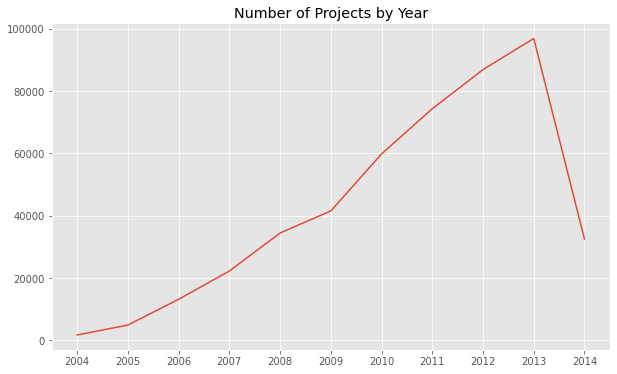

In [57]:
yr = projects[['year','projectid']].groupby("year").count().reset_index()
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(yr.year, yr.projectid, linestyle="-")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(yr.year)
plt.title('Number of Projects by Year')
plt.savefig('num_year.png', format='png')
plt.show()

In [58]:
grd_yr_dis = projects.groupby(['year','grade_level']).agg({'projectid': 'count'})
yr_dis = projects.groupby(['year']).agg({'projectid': 'count'})
grd_yr = grd_yr_dis.div(yr_dis, level='year') * 100
grd_yr = grd_yr.reset_index().sort_values(by=["year","grade_level"]).reset_index(drop=True)

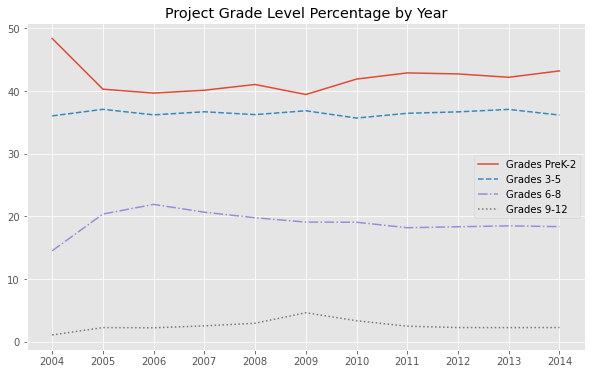

In [59]:
plt.figure(figsize=(10,6))
plt.plot(grd_yr[grd_yr["grade_level"]=="Grades PreK-2"].year, grd_yr[grd_yr["grade_level"]=="Grades PreK-2"].projectid, label = "Grades PreK-2", linestyle="-")
plt.plot(grd_yr[grd_yr["grade_level"]=="Grades 3-5"].year, grd_yr[grd_yr["grade_level"]=="Grades 3-5"].projectid, label = "Grades 3-5", linestyle="--")
plt.plot(grd_yr[grd_yr["grade_level"]=="Grades 6-8"].year, grd_yr[grd_yr["grade_level"]=="Grades 6-8"].projectid, label = "Grades 6-8", linestyle="-.")
plt.plot(grd_yr[grd_yr["grade_level"]=="Grades 9-12"].year, grd_yr[grd_yr["grade_level"]=="Grades 9-12"].projectid, label = "Grades 9-12", linestyle=":")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(grd_yr[grd_yr["grade_level"]=="Grades PreK-2"].year)
ax.legend(loc='best')
# plt.xlabel('Year')
# plt.ylabel('Percent')
plt.title('Project Grade Level Percentage by Year')
plt.savefig('grade_level.png', format='png')
plt.show()


In [60]:
price = projects[['year','total_price_excluding_optional_support',
       'total_price_including_optional_support']].groupby("year").mean().reset_index()

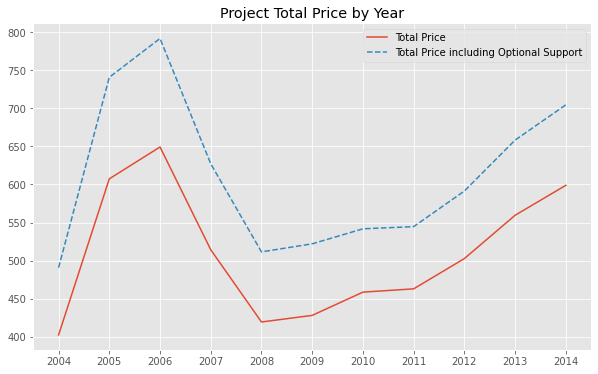

In [61]:
plt.figure(figsize=(10,6))
plt.plot(price.year, price.total_price_excluding_optional_support, label = "Total Price", linestyle="-")
plt.plot(price.year, price.total_price_including_optional_support, label = "Total Price including Optional Support", linestyle="--")
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(price.year)
ax.legend(loc='best')
plt.title('Project Total Price by Year')
plt.savefig('proj_price.png', format='png')
plt.show()

In [62]:
foc_yr_dis = projects.groupby(['year','primary_focus_area']).agg({'projectid': 'count'})
yr_dis = projects.groupby(['year']).agg({'projectid': 'count'})
foc_yr = foc_yr_dis.div(yr_dis, level='year') * 100
foc_yr = foc_yr.reset_index()
foc_yr_col = pd.DataFrame(list(itertools.product(projects.year.unique(), 
                                                 projects.primary_focus_area.unique())),
                         columns=['year', 'primary_focus_area'])
foc_yr_col = foc_yr_col.sort_values(by=["year","primary_focus_area"]).reset_index(drop=True)
foc_yr = pd.merge(foc_yr_col,foc_yr,how="left",on=["year","primary_focus_area"])
foc_yr.fillna(0,inplace=True)
foc_yr.head()

,year,primary_focus_area,projectid
0,2004,Applied Learning,11.781446
1,2004,Health & Sports,2.788845
2,2004,History & Civics,6.659078
3,2004,Literacy & Language,41.149687
4,2004,Math & Science,26.294821


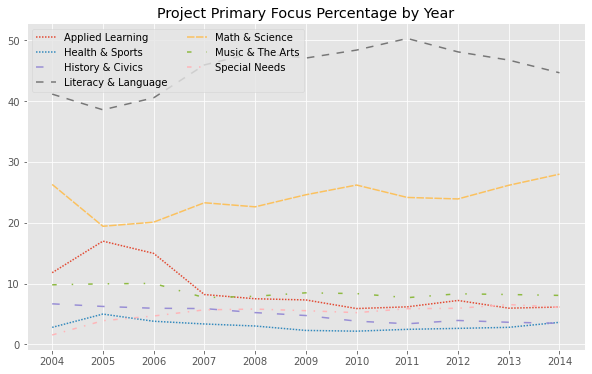

In [63]:
plt.figure(figsize=(10,6))
for i in range(len(foc_yr.primary_focus_area.unique())):
    plt.plot(foc_yr[foc_yr["primary_focus_area"]==foc_yr.primary_focus_area.unique()[i]].year, 
             foc_yr[foc_yr["primary_focus_area"]==foc_yr.primary_focus_area.unique()[i]].projectid, 
             label = foc_yr.primary_focus_area.unique()[i], 
             linestyle=linestyle_tuple[i][1])
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(foc_yr[foc_yr["primary_focus_area"]==foc_yr.primary_focus_area.unique()[0]].year)
ax.legend(loc='best',ncol=2)
plt.title('Project Primary Focus Percentage by Year')
plt.savefig('pri_focus.png', format='png')
plt.show()


In [64]:
res_yr_dis = projects.groupby(['year','resource_type']).agg({'projectid': 'count'})
yr_dis = projects.groupby(['year']).agg({'projectid': 'count'})
res_yr = res_yr_dis.div(yr_dis, level='year') * 100
res_yr = res_yr.reset_index()
res_yr_col = pd.DataFrame(list(itertools.product(projects.year.unique(), 
                                                 projects.resource_type.unique())),
                         columns=['year', 'resource_type'])
res_yr_col = res_yr_col.sort_values(by=["year","resource_type"]).reset_index(drop=True)
res_yr = pd.merge(res_yr_col,res_yr,how="left",on=["year","resource_type"])
res_yr.fillna(0,inplace=True)
res_yr.head()

,year,resource_type,projectid
0,2004,Books,22.822994
1,2004,Other,5.236198
2,2004,Supplies,54.126352
3,2004,Technology,13.944223
4,2004,Trips,3.870233


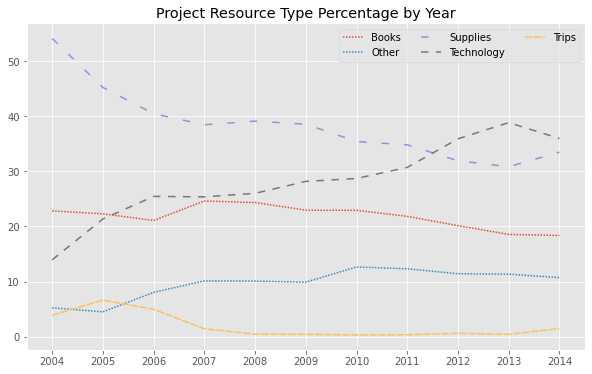

In [65]:
plt.figure(figsize=(10,6))
for i in range(len(res_yr.resource_type.unique())):
    plt.plot(res_yr[res_yr["resource_type"]==res_yr.resource_type.unique()[i]].year, 
             res_yr[res_yr["resource_type"]==res_yr.resource_type.unique()[i]].projectid, 
             label = res_yr.resource_type.unique()[i], 
             linestyle=linestyle_tuple[i][1])
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(res_yr[res_yr["resource_type"]==res_yr.resource_type.unique()[0]].year)
ax.legend(loc='best',ncol=3)
plt.title('Project Resource Type Percentage by Year')
plt.savefig('res_typ.png', format='png')
plt.show()


In [66]:
pov_yr_dis = projects.groupby(['year','poverty_level2']).agg({'projectid': 'count'})
yr_dis = projects.groupby(['year']).agg({'projectid': 'count'})
pov_yr = pov_yr_dis.div(yr_dis, level='year') * 100
pov_yr = pov_yr.reset_index()
pov_yr_col = pd.DataFrame(list(itertools.product(projects.year.unique(), 
                                                 projects.poverty_level2.unique())),
                         columns=['year', 'poverty_level2'])
pov_yr_col = pov_yr_col.sort_values(by=["year","poverty_level2"]).reset_index(drop=True)
pov_yr = pd.merge(pov_yr_col,pov_yr,how="left",on=["year","poverty_level2"])
pov_yr.fillna(0,inplace=True)
pov_yr.head()

,year,poverty_level2,projectid
0,2004,high-poverty,54.012521
1,2004,low-poverty,5.862265
2,2004,mid-high poverty,26.977803
3,2004,mid-low poverty,13.147410
4,2005,high-poverty,59.850324


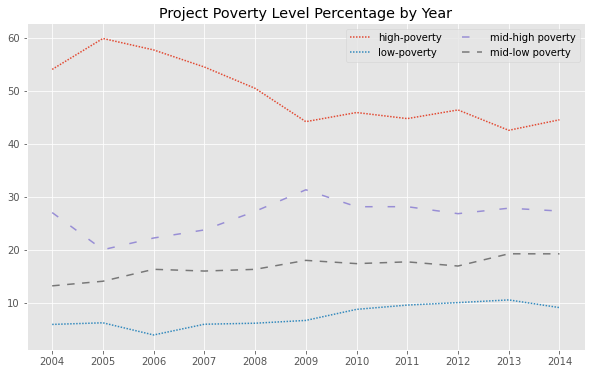

In [67]:
plt.figure(figsize=(10,6))
for i in range(len(pov_yr.poverty_level2.unique())):
    plt.plot(pov_yr[pov_yr["poverty_level2"]==pov_yr.poverty_level2.unique()[i]].year, 
             pov_yr[pov_yr["poverty_level2"]==pov_yr.poverty_level2.unique()[i]].projectid, 
             label = pov_yr.poverty_level2.unique()[i], 
             linestyle=linestyle_tuple[i][1])
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(pov_yr[pov_yr["poverty_level2"]==pov_yr.poverty_level2.unique()[0]].year)
ax.legend(loc='best',ncol=2)
plt.title('Project Poverty Level Percentage by Year')
plt.savefig('pov_level.png', format='png')
plt.show()


In [68]:
pov_yr_dis = projects.groupby(['year','poverty_level3']).agg({'projectid': 'count'})
yr_dis = projects.groupby(['year']).agg({'projectid': 'count'})
pov_yr = pov_yr_dis.div(yr_dis, level='year') * 100
pov_yr = pov_yr.reset_index()
pov_yr_col = pd.DataFrame(list(itertools.product(projects.year.unique(), 
                                                 projects.poverty_level3.unique())),
                         columns=['year', 'poverty_level3'])
pov_yr_col = pov_yr_col.sort_values(by=["year","poverty_level3"]).reset_index(drop=True)
pov_yr = pd.merge(pov_yr_col,pov_yr,how="left",on=["year","poverty_level3"])
pov_yr.fillna(0,inplace=True)
pov_yr.head()

,year,poverty_level3,projectid
0,2004,high-poverty,80.990324
1,2004,low-poverty,19.009676
2,2005,high-poverty,79.813916
3,2005,low-poverty,20.186084
4,2006,high-poverty,79.860638


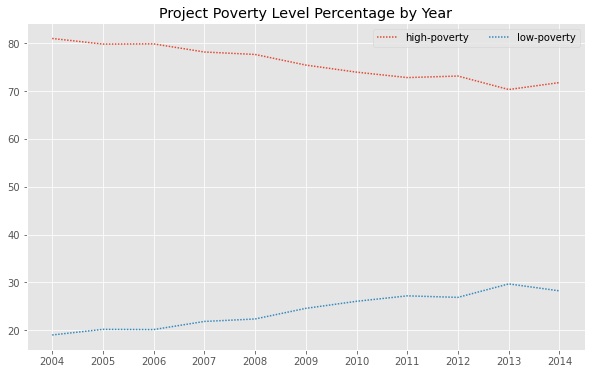

In [69]:
plt.figure(figsize=(10,6))
for i in range(len(pov_yr.poverty_level3.unique())):
    plt.plot(pov_yr[pov_yr["poverty_level3"]==pov_yr.poverty_level3.unique()[i]].year, 
             pov_yr[pov_yr["poverty_level3"]==pov_yr.poverty_level3.unique()[i]].projectid, 
             label = pov_yr.poverty_level3.unique()[i], 
             linestyle=linestyle_tuple[i][1])
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(pov_yr[pov_yr["poverty_level3"]==pov_yr.poverty_level3.unique()[0]].year)
ax.legend(loc='best',ncol=2)
plt.title('Project Poverty Level Percentage by Year')
plt.savefig('pov_level2.png', format='png')
plt.show()


In [70]:
pre_yr_dis = projects.groupby(['year','teacher_prefix']).agg({'projectid': 'count'})
yr_dis = projects.groupby(['year']).agg({'projectid': 'count'})
pre_yr = pre_yr_dis.div(yr_dis, level='year') * 100
pre_yr = pre_yr.reset_index()
pre_yr_col = pd.DataFrame(list(itertools.product(projects.year.unique(), 
                                                 projects.teacher_prefix.unique())),
                         columns=['year', 'teacher_prefix'])
pre_yr_col = pre_yr_col.sort_values(by=["year","teacher_prefix"]).reset_index(drop=True)
pre_yr = pd.merge(pre_yr_col,pre_yr,how="left",on=["year","teacher_prefix"])
pre_yr.fillna(0,inplace=True)
pre_yr.head()

,year,teacher_prefix,projectid
0,2004,Mr.,11.610700
1,2004,Mrs.,59.931702
2,2004,Ms.,28.457598
3,2005,Mr.,11.266181
4,2005,Mrs.,47.593042


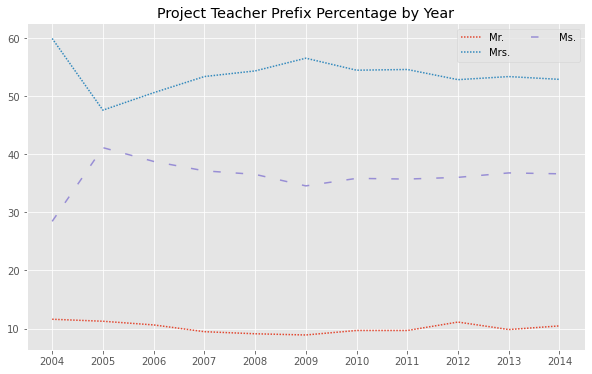

In [71]:
plt.figure(figsize=(10,6))
for i in range(len(pre_yr.teacher_prefix.unique())):
    plt.plot(pre_yr[pre_yr["teacher_prefix"]==pre_yr.teacher_prefix.unique()[i]].year, 
             pre_yr[pre_yr["teacher_prefix"]==pre_yr.teacher_prefix.unique()[i]].projectid, 
             label = pre_yr.teacher_prefix.unique()[i], 
             linestyle=linestyle_tuple[i][1])
ax = plt.gca()
ax.ticklabel_format(useOffset=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.xticks(pre_yr[pre_yr["teacher_prefix"]==pre_yr.teacher_prefix.unique()[0]].year)
ax.legend(loc='best',ncol=2)
plt.title('Project Teacher Prefix Percentage by Year')
plt.savefig('prefix_yr.png', format='png')
plt.show()


In [72]:
gender = projects.groupby(['teacher_prefix']).agg({'projectid': 'count'})
gender.reset_index(inplace=True)
gender

,teacher_prefix,projectid
0,Mr.,46698
1,Mrs.,252200
2,Ms.,169771


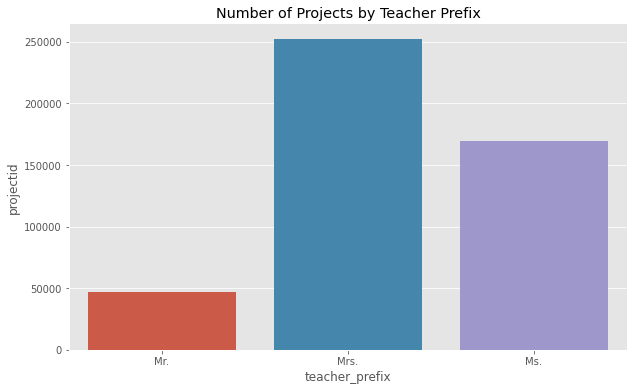

In [73]:
plt.figure(figsize=(10, 6))
sns.barplot(x="teacher_prefix", y="projectid", data=gender)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Number of Projects by Teacher Prefix')
plt.savefig('gender.png', format='png')
plt.show()

In [74]:
pre_grade = projects.groupby(['teacher_prefix','grade_level']).agg({'projectid': 'count'})
pre_grade.reset_index(inplace=True)
pre_grade.head()

,teacher_prefix,grade_level,projectid
0,Mr.,Grades 3-5,17854
1,Mr.,Grades 6-8,18307
2,Mr.,Grades 9-12,3748
3,Mr.,Grades PreK-2,6789
4,Mrs.,Grades 3-5,92307


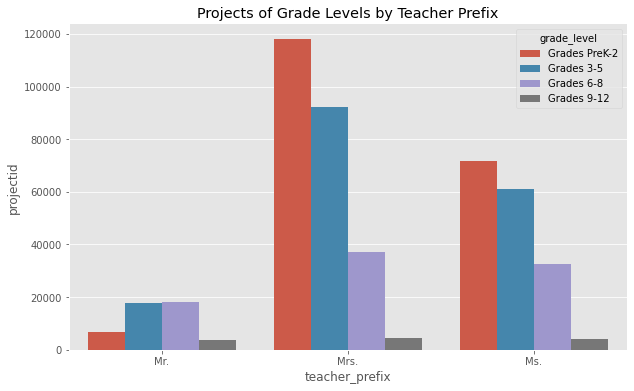

In [75]:
plt.figure(figsize=(10, 6))
hue_order = ['Grades PreK-2', 'Grades 3-5', 'Grades 6-8','Grades 9-12']
sns.barplot(x="teacher_prefix", y="projectid", hue="grade_level",hue_order=hue_order, data=pre_grade)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Grade Levels by Teacher Prefix')
plt.savefig('pre_grd.png', format='png')
plt.show()

In [76]:
pre_focus = projects.groupby(['teacher_prefix','primary_focus_area']).agg({'projectid': 'count'})
pre_focus.reset_index(inplace=True)
pre_focus

,teacher_prefix,primary_focus_area,projectid
0,Mr.,Applied Learning,2825
1,Mr.,Health & Sports,3215
2,Mr.,History & Civics,3303
3,Mr.,Literacy & Language,13995
4,Mr.,Math & Science,14399
5,Mr.,Music & The Arts,7174
6,Mr.,Special Needs,1787
7,Mrs.,Applied Learning,18254
8,Mrs.,Health & Sports,5590
9,Mrs.,History & Civics,9478


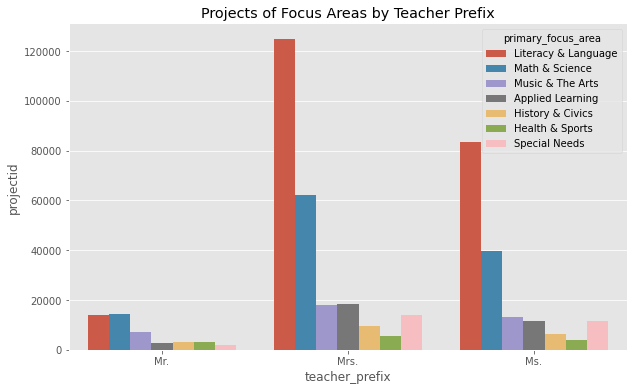

In [77]:
plt.figure(figsize=(10, 6))
hue_order = ["Literacy & Language","Math & Science","Music & The Arts","Applied Learning",
            "History & Civics","Health & Sports","Special Needs"]
sns.barplot(x="teacher_prefix", y="projectid", hue="primary_focus_area", hue_order=hue_order, data=pre_focus)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Focus Areas by Teacher Prefix')
plt.savefig('pre_focus.png', format='png')
plt.show()

In [78]:
pre_res = projects.groupby(['teacher_prefix','resource_type']).agg({'projectid': 'count'})
pre_res.reset_index(inplace=True)
pre_res.head()

,teacher_prefix,resource_type,projectid
0,Mr.,Books,7799
1,Mr.,Other,3923
2,Mr.,Supplies,14389
3,Mr.,Technology,20138
4,Mr.,Trips,449


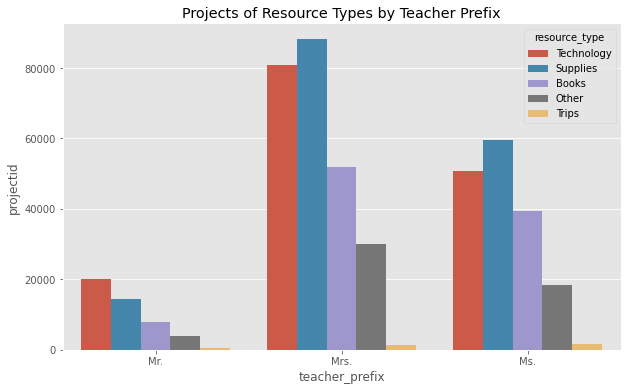

In [79]:
plt.figure(figsize=(10, 6))
hue_order = ["Technology","Supplies","Books","Other","Trips"]
sns.barplot(x="teacher_prefix", y="projectid", hue="resource_type",hue_order=hue_order, data=pre_res)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Resource Types by Teacher Prefix')
plt.savefig('pre_res.png', format='png')
plt.show()

In [80]:
pre_pov = projects.groupby(['teacher_prefix','poverty_level2']).agg({'projectid': 'count'})
pre_pov.reset_index(inplace=True)
pre_pov.head()

,teacher_prefix,poverty_level2,projectid
0,Mr.,high-poverty,22801
1,Mr.,low-poverty,3781
2,Mr.,mid-high poverty,11672
3,Mr.,mid-low poverty,8444
4,Mrs.,high-poverty,99652


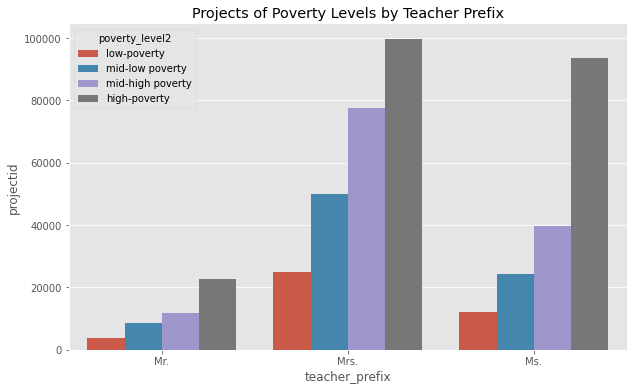

In [81]:
plt.figure(figsize=(10, 6))
hue_order = ["low-poverty","mid-low poverty","mid-high poverty","high-poverty"]
sns.barplot(x="teacher_prefix", y="projectid", hue="poverty_level2",hue_order=hue_order, data=pre_pov)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Poverty Levels by Teacher Prefix')
plt.savefig('pre_pov.png', format='png')
plt.show()

## Sentiment and writing

In [82]:
char = donor[['projectid','n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']]

In [83]:
chracter = pd.merge(projects,char,on="projectid",how="left")

In [84]:
cont_prefix = chracter[['fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'teacher_prefix','n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp',  'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].groupby('teacher_prefix').mean()

cont_list = list(chracter[['fulfillment_labor_materials','total_price_excluding_optional_support',
'total_price_including_optional_support', 'students_reached',
'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].mean())

for i in range(len(cont_prefix.columns)):
    cont_prefix[cont_prefix.columns[i]] = (cont_prefix[cont_prefix.columns[i]]-cont_list[i])/cont_list[i]
cont_prefix = cont_prefix*100
cont_prefix = cont_prefix.T

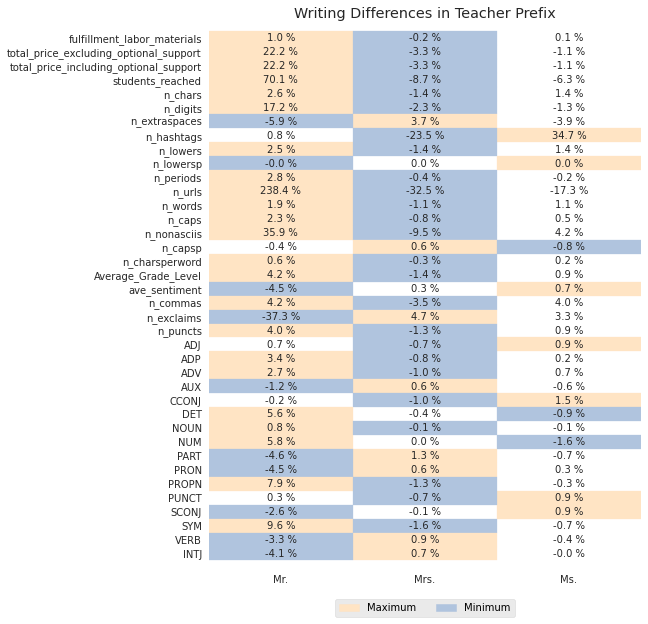

In [85]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(cont_prefix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.1f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)
for t in ax.texts: t.set_text(t.get_text() + " %")

row_max = cont_prefix.idxmax(axis=1)
row_min = cont_prefix.idxmin(axis=1)

for row, index in enumerate(cont_prefix.index):
    position1 = cont_prefix.columns.get_loc(row_max[index])
    position2 = cont_prefix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.1),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Writing Differences in Teacher Prefix')
plt.savefig('wri_pre.png', format='png')
plt.show()

In [86]:
cont_prefix = chracter[['resource_type',
                        'fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].groupby('resource_type').mean()

cont_list = list(chracter[['fulfillment_labor_materials','total_price_excluding_optional_support',
'total_price_including_optional_support', 'students_reached',
'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].mean())

for i in range(len(cont_prefix.columns)):
    cont_prefix[cont_prefix.columns[i]] = (cont_prefix[cont_prefix.columns[i]]-cont_list[i])/cont_list[i]
cont_prefix = cont_prefix*100
cont_prefix = cont_prefix.T

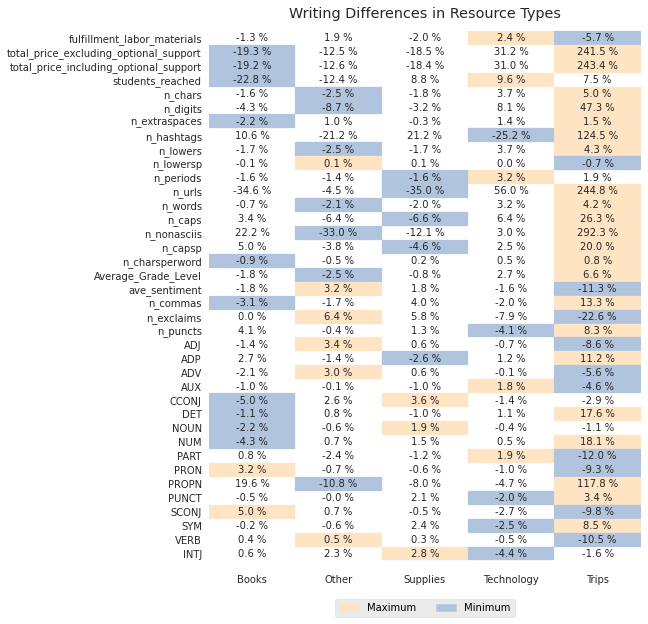

In [87]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(cont_prefix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.1f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)
for t in ax.texts: t.set_text(t.get_text() + " %")

row_max = cont_prefix.idxmax(axis=1)
row_min = cont_prefix.idxmin(axis=1)

for row, index in enumerate(cont_prefix.index):
    position1 = cont_prefix.columns.get_loc(row_max[index])
    position2 = cont_prefix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.1),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.title('Writing Differences in Resource Types')
plt.savefig('wri_res.png', format='png')
plt.show()

In [88]:
cont_prefix = chracter[['primary_focus_area',
                        'fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].groupby('primary_focus_area').mean()

cont_list = list(chracter[['fulfillment_labor_materials','total_price_excluding_optional_support',
'total_price_including_optional_support', 'students_reached',
'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].mean())

for i in range(len(cont_prefix.columns)):
    cont_prefix[cont_prefix.columns[i]] = (cont_prefix[cont_prefix.columns[i]]-cont_list[i])/cont_list[i]
cont_prefix = cont_prefix*100
cont_prefix = cont_prefix.T

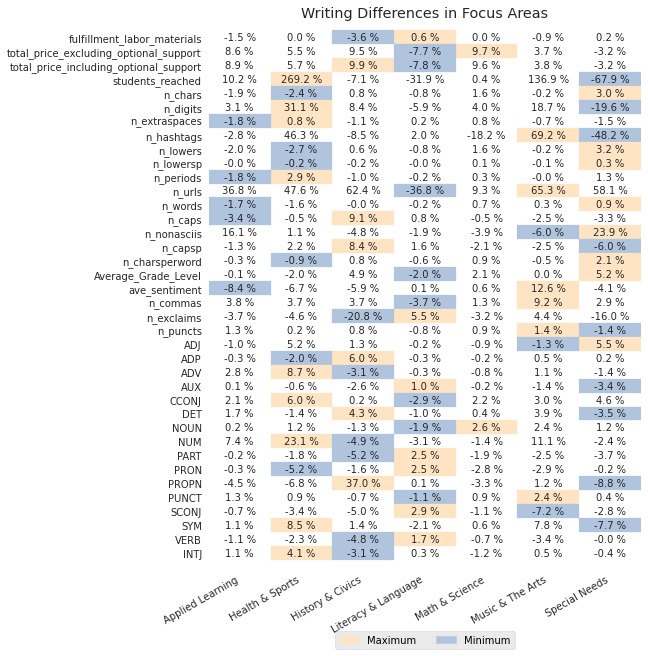

In [89]:
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(cont_prefix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.1f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)
for t in ax.texts: t.set_text(t.get_text() + " %")

row_max = cont_prefix.idxmax(axis=1)
row_min = cont_prefix.idxmin(axis=1)

for row, index in enumerate(cont_prefix.index):
    position1 = cont_prefix.columns.get_loc(row_max[index])
    position2 = cont_prefix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.16),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
ax.set_xticklabels(ax.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.title('Writing Differences in Focus Areas')
plt.savefig('wri_foc.png', format='png')
plt.show()

In [90]:
cont_prefix = chracter[['grade_level',
                        'fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].groupby('grade_level').mean()

cont_list = list(chracter[['fulfillment_labor_materials','total_price_excluding_optional_support',
'total_price_including_optional_support', 'students_reached',
'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].mean())

for i in range(len(cont_prefix.columns)):
    cont_prefix[cont_prefix.columns[i]] = (cont_prefix[cont_prefix.columns[i]]-cont_list[i])/cont_list[i]
cont_prefix = cont_prefix*100
cont_prefix = cont_prefix.T

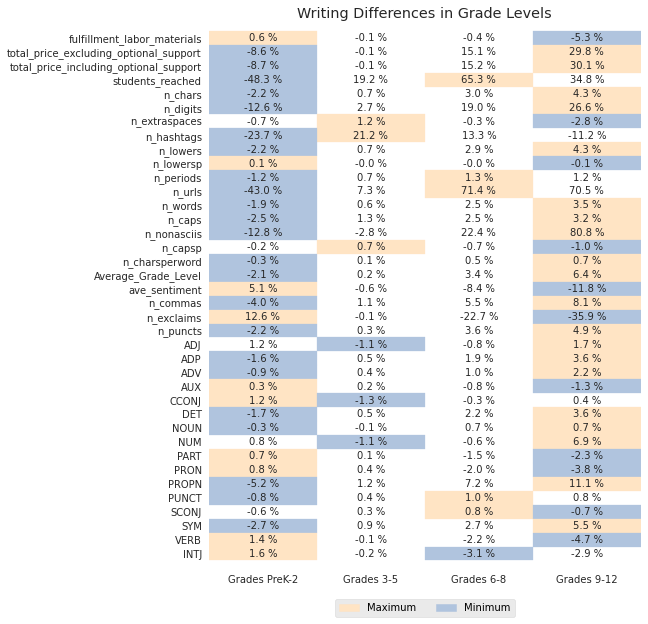

In [91]:
cont_prefix = cont_prefix[["Grades PreK-2","Grades 3-5","Grades 6-8","Grades 9-12"]]
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(cont_prefix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.1f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)
for t in ax.texts: t.set_text(t.get_text() + " %")

row_max = cont_prefix.idxmax(axis=1)
row_min = cont_prefix.idxmin(axis=1)

for row, index in enumerate(cont_prefix.index):
    position1 = cont_prefix.columns.get_loc(row_max[index])
    position2 = cont_prefix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.1),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.title('Writing Differences in Grade Levels')
plt.savefig('wri_grd.png', format='png')
plt.show()

In [92]:
cont_prefix = chracter[['poverty_level2',
                        'fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].groupby('poverty_level2').mean()

cont_list = list(chracter[['fulfillment_labor_materials','total_price_excluding_optional_support',
'total_price_including_optional_support', 'students_reached',
'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].mean())

for i in range(len(cont_prefix.columns)):
    cont_prefix[cont_prefix.columns[i]] = (cont_prefix[cont_prefix.columns[i]]-cont_list[i])/cont_list[i]
cont_prefix = cont_prefix*100
cont_prefix = cont_prefix.T

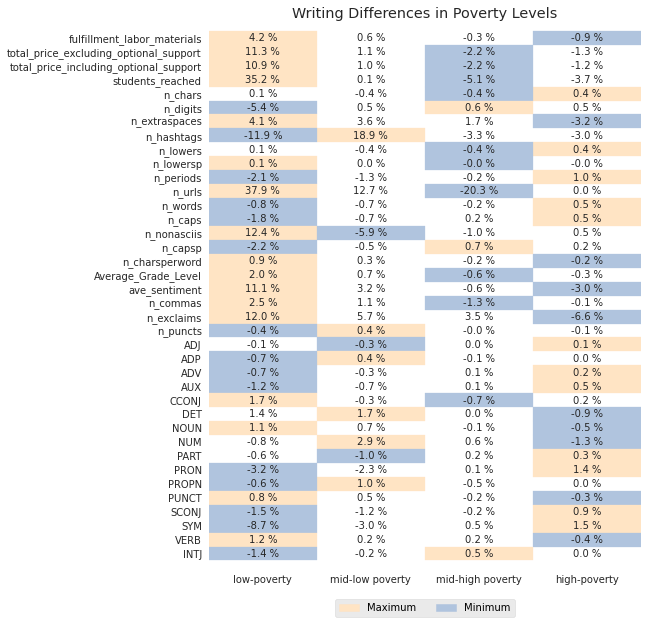

In [93]:
cont_prefix = cont_prefix[["low-poverty","mid-low poverty","mid-high poverty","high-poverty"]]
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(cont_prefix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.1f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)
for t in ax.texts: t.set_text(t.get_text() + " %")

row_max = cont_prefix.idxmax(axis=1)
row_min = cont_prefix.idxmin(axis=1)

for row, index in enumerate(cont_prefix.index):
    position1 = cont_prefix.columns.get_loc(row_max[index])
    position2 = cont_prefix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.1),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.title('Writing Differences in Poverty Levels')
plt.savefig('wri_pov.png', format='png')
plt.show()

### Correlation

In [94]:
corrMatrix = chracter[["totenrl","perwht","perfrl","perecd","gifted_tot","disab_tot","lep",
               'fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].corr()
corrMatrix = corrMatrix[['fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']]
corrMatrix = corrMatrix.T
corrMatrix = corrMatrix[["totenrl","perwht","perfrl","perecd","gifted_tot","disab_tot","lep"]]

In [95]:
corrMatrix

,totenrl,perwht,perfrl,perecd,gifted_tot,disab_tot,lep
fulfillment_labor_materials,0.017513,0.009413,-0.053926,-0.035159,0.010601,-0.038748,0.031533
total_price_excluding_optional_support,0.014571,-0.007134,-0.015628,-0.011589,0.018437,-0.012103,0.003666
total_price_including_optional_support,0.014354,-0.007360,-0.014665,-0.010846,0.018202,-0.011574,0.003410
students_reached,0.008826,0.000072,-0.003017,-0.003095,0.010059,0.001829,-0.002155
n_chars,0.007690,-0.033943,0.008575,0.016499,0.004637,-0.004763,0.034041
n_digits,0.024870,-0.001244,0.012856,0.010443,0.017213,-0.001847,0.012816
n_extraspaces,-0.015336,0.065782,-0.042209,-0.042510,-0.000301,0.019359,-0.036760
n_hashtags,0.002392,-0.002742,-0.000110,0.000200,-0.000010,0.001527,0.005650
n_lowers,0.007230,-0.033367,0.008049,0.016010,0.003633,-0.004258,0.033136
n_lowersp,-0.009526,0.011783,-0.014246,-0.011832,-0.020839,0.012281,-0.019684


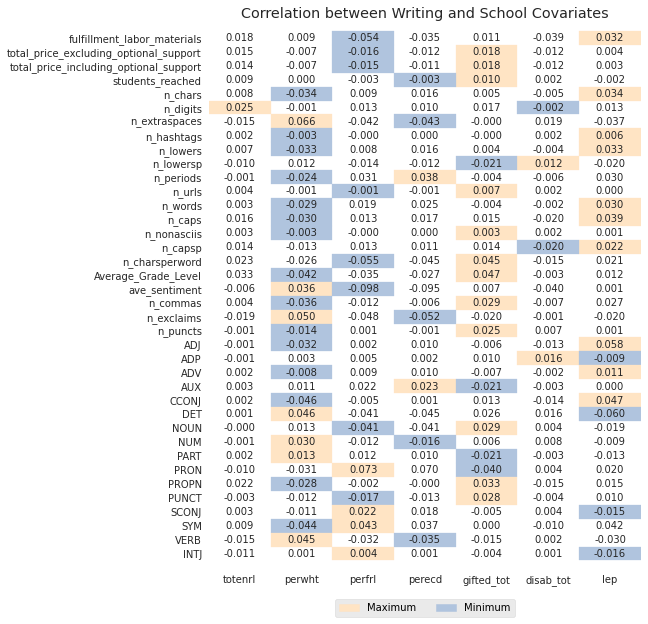

In [96]:
# cont_prefix = cont_prefix[["low-poverty","mid-low poverty","mid-high poverty","high-poverty"]]
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(corrMatrix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.3f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)
# for t in ax.texts: t.set_text(t.get_text() + " %")

row_max = corrMatrix.idxmax(axis=1)
row_min = corrMatrix.idxmin(axis=1)

for row, index in enumerate(corrMatrix.index):
    position1 = corrMatrix.columns.get_loc(row_max[index])
    position2 = corrMatrix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.1),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.title('Correlation between Writing and School Covariates')
plt.savefig('cor_sch.png', format='png')
plt.show()

In [97]:
corrMatrix = chracter[["cs_mn_avg_ol","cs_mn_coh_ol","cs_mn_grd_ol","cs_mn_mth_ol",
               'fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']].corr()
corrMatrix = corrMatrix[['fulfillment_labor_materials','total_price_excluding_optional_support',
                        'total_price_including_optional_support', 'students_reached',
                        'n_chars', 'n_digits', 'n_extraspaces', 'n_hashtags',
                        'n_lowers', 'n_lowersp', 'n_periods', 'n_urls', 'n_words',
                        'n_caps', 'n_nonasciis', 'n_capsp', 'n_charsperword','Average_Grade_Level',
                        'ave_sentiment', 'n_commas', 'n_exclaims', 'n_puncts', 'ADJ', 'ADP',
                        'ADV', 'AUX', 'CCONJ', 'DET', 'NOUN', 'NUM', 'PART', 'PRON', 'PROPN',
                        'PUNCT', 'SCONJ', 'SYM', 'VERB', 'INTJ']]
corrMatrix = corrMatrix.T
corrMatrix = corrMatrix[["cs_mn_avg_ol","cs_mn_coh_ol","cs_mn_grd_ol","cs_mn_mth_ol"]]

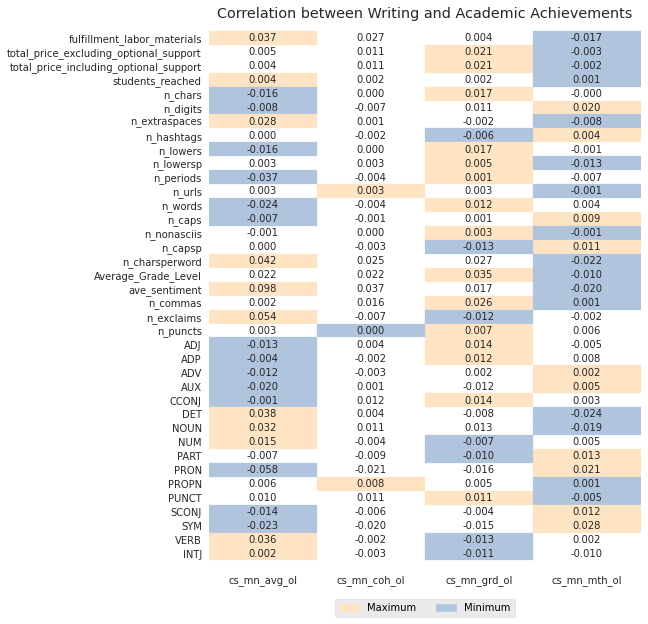

In [98]:
# cont_prefix = cont_prefix[["low-poverty","mid-low poverty","mid-high poverty","high-poverty"]]
plt.figure(figsize=(10, 10))
plt.subplots_adjust(left=0.3)
with sns.axes_style('white'):
    ax = sns.heatmap(corrMatrix,
                cbar=False,
                square=False,
                annot=True,
                fmt='.3f',
                cmap=ListedColormap(['white']),
                linewidths=0.3, cbar_kws={"shrink": .5},xticklabels=True, yticklabels=True)
ax.set(xlabel=None)

row_max = corrMatrix.idxmax(axis=1)
row_min = corrMatrix.idxmin(axis=1)

for row, index in enumerate(corrMatrix.index):
    position1 = corrMatrix.columns.get_loc(row_max[index])
    position2 = corrMatrix.columns.get_loc(row_min[index])
    ax.add_patch(Rectangle((position1, row),1,1, fill=True,color='bisque', edgecolor='red', lw=0.3,))
    ax.add_patch(Rectangle((position2, row),1,1, fill=True, color='lightsteelblue',edgecolor='red', lw=0.3))

high_patch = mpatches.Patch(color='bisque', label='Maximum')
low_patch = mpatches.Patch(color='lightsteelblue', label='Minimum')

plt.legend(handles=[high_patch, low_patch],loc='lower center', bbox_to_anchor=(0.5,-0.1),ncol=2)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
# ax.set_xticklabels(ax.get_xticklabels(), rotation=30,horizontalalignment='right')
plt.title('Correlation between Writing and Academic Achievements')
plt.savefig('cor_ach.png', format='png')
plt.show()

In [99]:
pov_res = projects.groupby(['poverty_level3','resource_type']).agg({'projectid': 'count'})
pov_sum = projects.groupby(['poverty_level3']).agg({'projectid': 'count'})
pov_res = pov_res.div(pov_sum, level='poverty_level3')
pov_res.reset_index(inplace=True)
pov_res.head()


,poverty_level3,resource_type,projectid
0,high-poverty,Books,0.217515
1,high-poverty,Other,0.113859
2,high-poverty,Supplies,0.357460
3,high-poverty,Technology,0.303002
4,high-poverty,Trips,0.008164


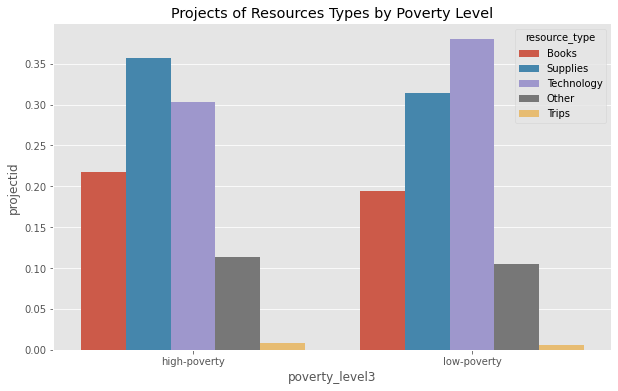

In [100]:
plt.figure(figsize=(10, 6))
hue_order = ['Books', 'Supplies', 'Technology','Other','Trips']
# ,
sns.barplot(x="poverty_level3", y="projectid", hue="resource_type",hue_order=hue_order, data=pov_res)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Resources Types by Poverty Level')
plt.savefig('pov_res.png', format='png')
plt.show()

In [101]:
pov_foc = projects.groupby(['poverty_level3','primary_focus_area']).agg({'projectid': 'count'})
pov_sum = projects.groupby(['poverty_level3']).agg({'projectid': 'count'})
pov_foc = pov_foc.div(pov_sum, level='poverty_level3')
pov_foc.reset_index(inplace=True)
pov_foc

,poverty_level3,primary_focus_area,projectid
0,high-poverty,Applied Learning,0.071163
1,high-poverty,Health & Sports,0.027644
2,high-poverty,History & Civics,0.039410
3,high-poverty,Literacy & Language,0.482261
4,high-poverty,Math & Science,0.240101
5,high-poverty,Music & The Arts,0.082903
6,high-poverty,Special Needs,0.056518
7,low-poverty,Applied Learning,0.064979
8,low-poverty,Health & Sports,0.026474
9,low-poverty,History & Civics,0.044697


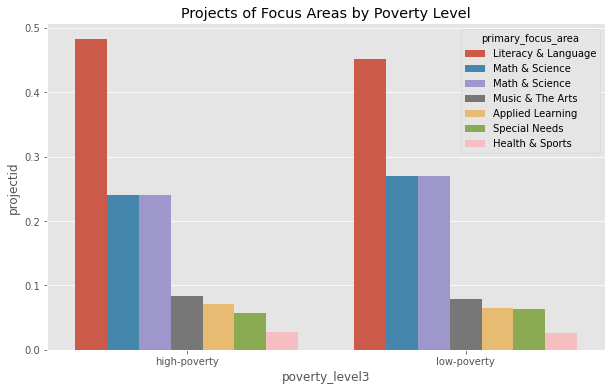

In [102]:
plt.figure(figsize=(10, 6))
hue_order = ['Literacy & Language', 'Math & Science', 'Math & Science','Music & The Arts',
             'Applied Learning','Special Needs','Health & Sports']

sns.barplot(x="poverty_level3", y="projectid", hue="primary_focus_area",hue_order=hue_order, data=pov_foc)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Focus Areas by Poverty Level')
plt.savefig('pov_foc.png', format='png')
plt.show()

In [103]:
pov_grd = projects.groupby(['poverty_level3','grade_level']).agg({'projectid': 'count'})
pov_sum = projects.groupby(['poverty_level3']).agg({'projectid': 'count'})
pov_grd = pov_grd.div(pov_sum, level='poverty_level3')
pov_grd.reset_index(inplace=True)
pov_grd.head()

,poverty_level3,grade_level,projectid
0,high-poverty,Grades 3-5,0.365421
1,high-poverty,Grades 6-8,0.183804
2,high-poverty,Grades 9-12,0.025240
3,high-poverty,Grades PreK-2,0.425529
4,low-poverty,Grades 3-5,0.364827


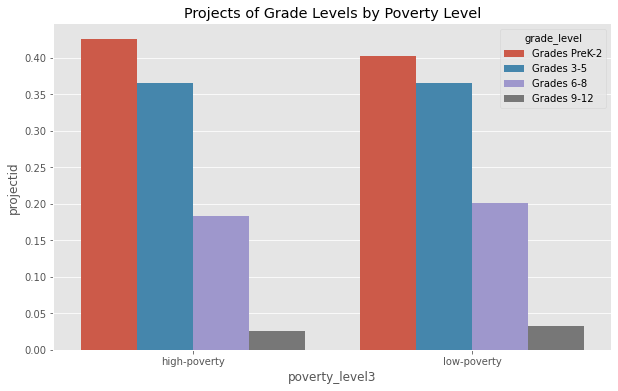

In [104]:
plt.figure(figsize=(10, 6))
hue_order = ['Grades PreK-2', 'Grades 3-5', 'Grades 6-8','Grades 9-12']

sns.barplot(x="poverty_level3", y="projectid", hue="grade_level", hue_order=hue_order, data=pov_grd)
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.title('Projects of Grade Levels by Poverty Level')
plt.savefig('pov_grd.png', format='png')
plt.show()